In [1]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline,linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import keras
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

## Load Data

In [3]:
train_articles = os.listdir("datasets-v2/datasets/train-articles")
train_labels_tags_span = os.listdir("datasets-v2/datasets/train-labels-task1-span-identification")
train_tags_technique = os.listdir("datasets-v2/datasets/train-labels-task2-technique-classification")
train_articles.sort()
train_labels_tags_span.sort()

## Data Preprocessing 

In [4]:
## Step 1: Gather tables from Task 1 folder and place them into a dict type where the article number is the key

# Dictionary containing news articlc
propTagsSpan = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets-v2/datasets/train-labels-task1-span-identification/"+ articleNoExt + ".task1-SI.labels"
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsSpan[articleNoExt] = tags
    r.close()
    
print(propTagsSpan[train_articles[0]])

['111111111 265 323 ', '111111111 1795 1935 ', '111111111 149 157 ', '111111111 1069 1091 ', '111111111 1334 1462 ', '111111111 1577 1616 ', '111111111 2023 2086 ']


In [5]:
#Step 2: Do the same for task 2
propagandaTagTechnique = os.listdir("datasets-v2/datasets/train-labels-task2-technique-classification")
propagandaTagTechnique.sort()
propTagsTechnique = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets-v2/datasets/train-labels-task2-technique-classification/"+ articleNoExt + ".task2-TC.labels"
    
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace(articleNo, " ")
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsTechnique [articleNoExt] = tags
    r.close()
    
print(propTagsTechnique[train_articles[0]])

['  Appeal_to_Authority 265 323 ', '  Appeal_to_Authority 1795 1935 ', '  Doubt 149 157 ', '  Repetition 1069 1091 ', '  Appeal_to_fear-prejudice 1334 1462 ', '  Appeal_to_fear-prejudice 1577 1616 ', '  Appeal_to_fear-prejudice 1856 1910 ', '  Appeal_to_fear-prejudice 2023 2086 ']


In [6]:
#Step 3: Put sentences that have annotation "propoganda" as a list
propoganda_sent_span = []

for article in train_articles:
    article_path = "datasets-v2/datasets/train-articles/" + article + ".txt"
    tags = propTagsSpan[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            
            propoganda_sent_span.append(tag_line)
    r.close()

print(propoganda_sent_span[0])

The next transmission could be more pronounced or stronger


In [7]:
#Step 4: Create a dictionary with the keys being the propoganda sentences and the values being their associated propoganda type.
propoganda_techniques = {}
propoganda_techniques["Sentence"] = []
propoganda_techniques["Technique"] = []

for article in train_articles:
    article_path = "datasets-v2/datasets/train-articles/" + article + ".txt"
    tags = propTagsTechnique[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            propoganda_techniques["Technique"].append(tag[0])
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            propoganda_techniques["Sentence"].append(tag_line)     
    r.close()  

In [8]:
###Step 5: Using the list of propoganda sentences to create a list of non propoganda sentences
#Step 5: Convert dictionary into DataFrame
df = pd.DataFrame.from_dict(propoganda_techniques)
df

,Sentence,Technique
0,The next transmission could be more pronounced...,Appeal_to_Authority
1,when (the plague) comes again it starts from m...,Appeal_to_Authority
2,appeared,Doubt
3,"a very, very different",Repetition
4,He also pointed to the presence of the pneumon...,Appeal_to_fear-prejudice
...,...,...
6124,the Left killed comedy,Slogans
6125,"no one looks in the mirror and thinks, ‘this b...","Exaggeration,Minimisation"
6126,Columbia snowflakes,"Name_Calling,Labeling"
6127,"Comrades, these jokes you have been listening ...","Exaggeration,Minimisation"


## Data Exploration

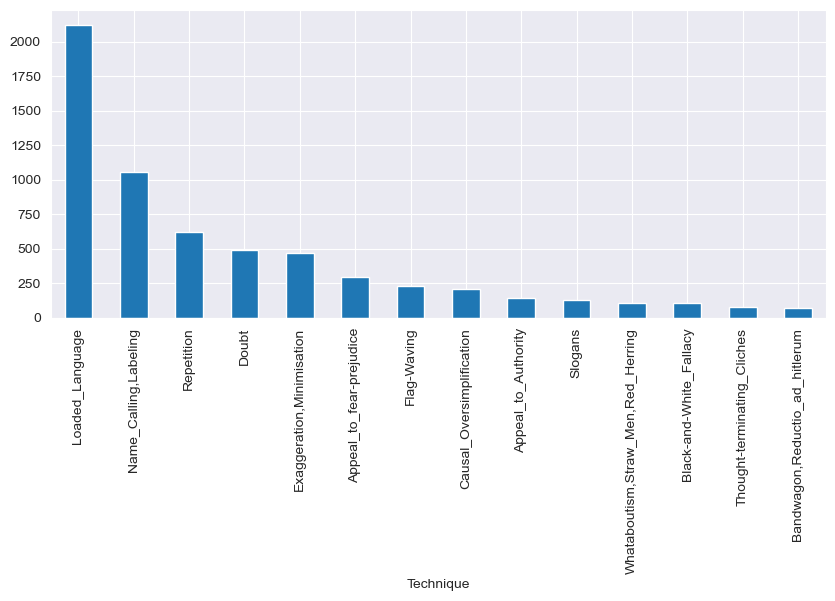

In [9]:
propoganda_techniques_tags = ['Appeal_to_Authority','Name_Calling,Labeling','Slogans', 'Loaded_Language','Appeal_to_fear-prejudice','Repetition','Doubt','Exaggeration,Minimisation','Flag-Waving','Causal_Oversimplification','Whataboutism,Straw_Men,Red_Herring','Black-and-White_Fallacy','Thought-terminating_Cliches','Bandwagon,Reductio_ad_hitlerum']
plt.figure(figsize=(10,4))
df.Technique.value_counts().plot(kind='bar');

In [10]:
# Choosing only these 7 columns as they are the most common propaganda techniques which we could identify
columns_to_keep = ['Name_Calling,Labeling', 'Loaded_Language','Repetition','Doubt','Exaggeration,Minimisation','Flag-Waving','Causal_Oversimplification']
df = df[df['Technique'].isin(columns_to_keep)]

In [11]:
df

,Sentence,Technique
2,appeared,Doubt
3,"a very, very different",Repetition
11,the nation that gave the world the Magna Carta...,Loaded_Language
12,The UK should never become a stage for inflamm...,Flag-Waving
13,hate preachers,"Name_Calling,Labeling"
...,...,...
6123,Also the Left killed comedy. This is what its ...,"Exaggeration,Minimisation"
6125,"no one looks in the mirror and thinks, ‘this b...","Exaggeration,Minimisation"
6126,Columbia snowflakes,"Name_Calling,Labeling"
6127,"Comrades, these jokes you have been listening ...","Exaggeration,Minimisation"


## Text Preprocessing

In [13]:
def clean_text(text):
    text = text.lower() #convert to lowercase
    # Not removing punctuations as they are important in this context to identify the propaganda type
    text = re.sub(r'\d+', '', text) # remove numbers
    text = text.strip() #remove whitespaces
    return text

df2 = df.copy()
df2['Cleaned_Sentence'] = df2['Sentence'].apply(lambda x: clean_text(x))

In [14]:
df2

,Sentence,Technique,Cleaned_Sentence
2,appeared,Doubt,appeared
3,"a very, very different",Repetition,"a very, very different"
11,the nation that gave the world the Magna Carta...,Loaded_Language,the nation that gave the world the magna carta...
12,The UK should never become a stage for inflamm...,Flag-Waving,the uk should never become a stage for inflamm...
13,hate preachers,"Name_Calling,Labeling",hate preachers
...,...,...,...
6123,Also the Left killed comedy. This is what its ...,"Exaggeration,Minimisation",also the left killed comedy. this is what its ...
6125,"no one looks in the mirror and thinks, ‘this b...","Exaggeration,Minimisation","no one looks in the mirror and thinks, ‘this b..."
6126,Columbia snowflakes,"Name_Calling,Labeling",columbia snowflakes
6127,"Comrades, these jokes you have been listening ...","Exaggeration,Minimisation","comrades, these jokes you have been listening ..."


## DTM and TF-IDF with Random Forest

In [15]:
#Tf-idf vectorization
 
vectorizer = TfidfVectorizer(
    stop_words="english",  # Remove common English stop words
    ngram_range=(1,1),  # Consider unigrams
    min_df=5,  # Ignore terms that appear in less than 3 documents
    max_df=0.85  # Ignore terms that appear in more than 80% of documents
)
 
X = vectorizer.fit_transform(df2['Cleaned_Sentence'])
features = vectorizer.get_feature_names_out()

DTM = pd.DataFrame(X.toarray(), columns=features)
DTM.shape

(5199, 968)

In [16]:
DTM

,abiding,absolute,absolutely,absurd,abuse,abuses,according,accusations,accused,act,...,worldwide,worse,worst,wouldn,wrath,wrong,wrote,year,years,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


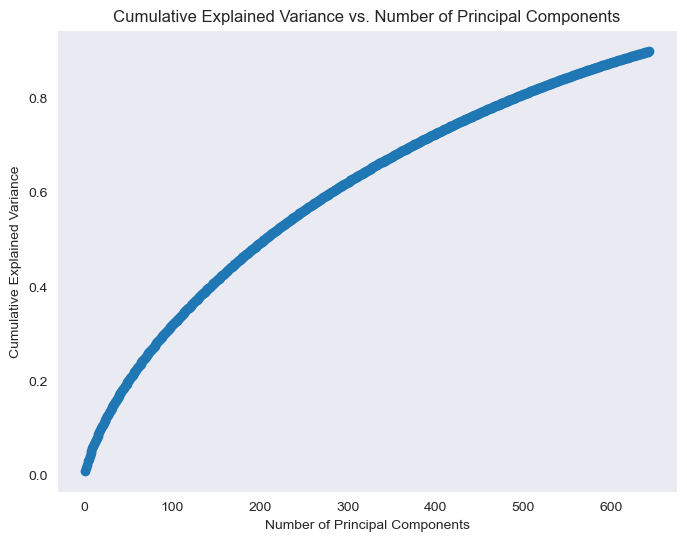

In [17]:
# PCA 
# Initialize PCA model
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9, random_state=42)
DTM_reduced = pca.fit_transform(DTM)

# Step 2: To find best n_components for pca
 
# Calculate the cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()
 
# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()

In [18]:
n_components = 600
pca = PCA(n_components=n_components, random_state=42)
DTM_reduced = pca.fit_transform(DTM)


Accuracy: 0.54
Precision: 0.56
Recall: 0.54
F1 Score: 0.50


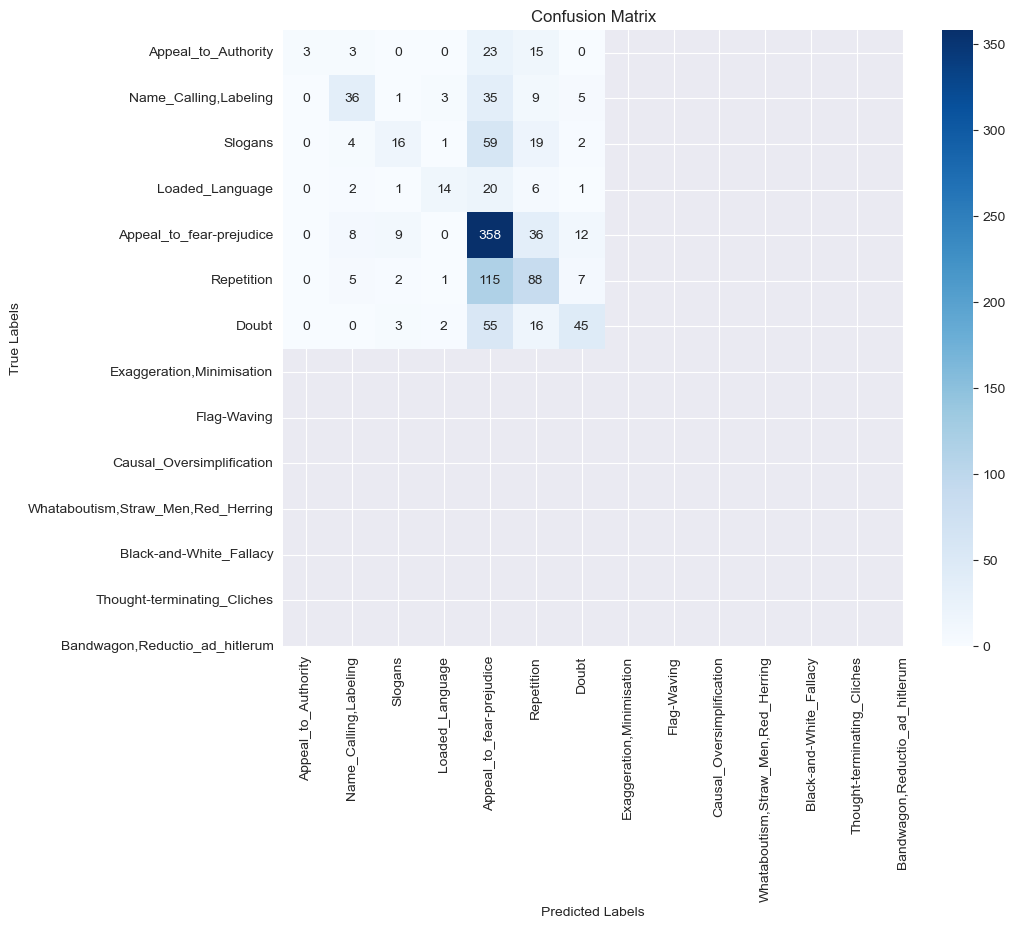

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(DTM_reduced, df2['Technique'], test_size=0.2, random_state=42)

# Initialize the Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

#Precision, Recall, F1 Score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))

import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=propoganda_techniques_tags, yticklabels=propoganda_techniques_tags)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Word Embeddings(Fasttext) with RNN, CNN

In [20]:
from gensim.models import fasttext

# Path to the pretrained model files
model_bin_path = "crawl-300d-2M-subword.bin"
model_ft = fasttext.load_facebook_model(model_bin_path)

In [30]:
import numpy as np
def create_mean_vectors_fasttext(model_name, data_frame, column_name):
    mean_vectors = []
    for index, row in data_frame.iterrows():
        words = row[column_name]
        word_vectors = []
        for word in words:
            # if word in model_name:
            vector = model_name[word]
            word_vectors.append(vector)
        if word_vectors:
            mean_vector = np.mean(word_vectors, axis=0)
            mean_vectors.append(mean_vector)
        else:
            mean_vectors.append(np.zeros(300))
    mean_vectors = np.array(mean_vectors)
    return mean_vectors

# Create a DataFrame with the new mean columns
def create_mean_columns(mean_vectors, data_frame):
    mean_columns = pd.DataFrame(mean_vectors, columns=['mean_vector_' + str(i) for i in range(1,mean_vectors.shape[1]+1)])
    mean_columns.index = data_frame.index
    return mean_columns

def create_new_df(mean_vectors, data_frame):
    new_df = pd.concat([mean_vectors, data_frame['Technique']], axis=1)
    return new_df

def drop_technique_column(data_frame):
    saved_overall = data_frame['Technique']
    data_frame = data_frame.drop('Technique', axis=1)
    return data_frame, saved_overall

In [32]:
mean_vectors_ft = create_mean_vectors_fasttext(model_ft.wv, df2, 'Cleaned_Sentence')
mean_columns3 = create_mean_columns(mean_vectors_ft, df2)
mean_columns3 = create_new_df(mean_columns3, df2)
new_df3,saved_overall3 = drop_technique_column(mean_columns3)

In [33]:
new_df3

,mean_vector_1,mean_vector_2,mean_vector_3,mean_vector_4,mean_vector_5,mean_vector_6,mean_vector_7,mean_vector_8,mean_vector_9,mean_vector_10,...,mean_vector_291,mean_vector_292,mean_vector_293,mean_vector_294,mean_vector_295,mean_vector_296,mean_vector_297,mean_vector_298,mean_vector_299,mean_vector_300
2,0.101382,0.037906,-0.039431,0.053606,0.060833,0.128206,-0.023722,0.035046,0.041132,-0.030514,...,-0.080282,-0.040382,0.168977,-0.059496,0.120637,0.061137,0.034715,0.121274,0.155800,0.058982
3,0.088103,0.087478,-0.016648,0.081949,0.057841,0.018673,-0.044263,0.029903,0.017374,-0.012410,...,-0.019590,-0.012288,0.186842,-0.057643,0.113862,0.028666,-0.029432,0.142586,0.090422,0.007384
11,0.090960,0.071919,0.036368,0.073365,0.035966,-0.017694,-0.038823,0.003723,0.001225,-0.017174,...,-0.026730,-0.031764,0.166291,-0.062426,0.098791,0.034416,-0.036798,0.098916,0.083418,0.014548
12,0.077307,0.056260,0.024314,0.095445,0.060696,0.018793,-0.061963,0.003615,0.030440,-0.028769,...,-0.020823,-0.016950,0.173642,-0.069048,0.100184,0.031326,-0.030283,0.118221,0.098877,0.031174
13,0.084800,0.055372,0.021876,0.123403,0.079196,0.039677,-0.065898,-0.011816,0.030567,-0.025606,...,-0.048422,-0.035001,0.170383,-0.062627,0.095372,0.033360,-0.008036,0.148269,0.139427,0.042330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6123,0.104666,0.049459,0.039136,0.076794,0.041532,-0.000982,-0.068872,-0.000869,-0.005126,-0.023448,...,-0.010821,-0.004913,0.213141,-0.057103,0.115697,0.018250,-0.032363,0.113037,0.088132,0.018885
6125,0.093727,0.060158,0.037466,0.068929,0.028224,-0.012762,-0.053773,-0.002089,-0.005173,-0.022386,...,-0.011403,-0.016637,0.194626,-0.074922,0.111402,0.022085,-0.042959,0.088873,0.065049,0.017354
6126,0.079748,0.048932,0.007145,0.088452,0.043579,0.055563,-0.077180,0.001162,0.057490,-0.039809,...,0.004960,-0.006418,0.161792,-0.075741,0.134676,0.037611,-0.028234,0.097367,0.117325,0.046933
6127,0.095700,0.060977,0.028380,0.098211,0.051189,-0.005093,-0.067945,-0.006662,0.016461,-0.023358,...,-0.020770,-0.027169,0.191678,-0.067300,0.115664,0.019412,-0.034551,0.119752,0.092577,0.024938


In [34]:
saved_overall3

2                           Doubt
3                      Repetition
11                Loaded_Language
12                    Flag-Waving
13          Name_Calling,Labeling
                  ...            
6123    Exaggeration,Minimisation
6125    Exaggeration,Minimisation
6126        Name_Calling,Labeling
6127    Exaggeration,Minimisation
6128    Exaggeration,Minimisation
Name: Technique, Length: 5199, dtype: object

In [38]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

def final_data(new_df,saved_overall,name):
    
    #Initialize PCA
    pca = PCA(n_components=0.90, random_state=42)
    red_data = pca.fit_transform(new_df)
    
    # To find best n_components for pca - Calculate the cumulative explained variance
    cumulative_variance = pca.explained_variance_ratio_.cumsum()
    
    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs. Number of Principal Components')
    plt.grid()
    plt.show()
    
    # Find best n_components
    explained_variance_threshold = 0.90
    n_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1
    print(f"Number of PCA components selected for {name}= {n_components}")
    
    # Use best n_components and reduce the features
    pca = PCA(n_components=n_components, random_state=42)
    final_reduced_data = pca.fit_transform(new_df)
    final_reduced_data = pd.DataFrame(final_reduced_data, columns=['PC' + str(i) for i in range(1,n_components+1)])
    final_reduced_data.index = new_df.index
    final_data = pd.concat([final_reduced_data, saved_overall], axis=1)
    print("----------------------------------------")
    return final_data

Dimension reduction for Fasttext


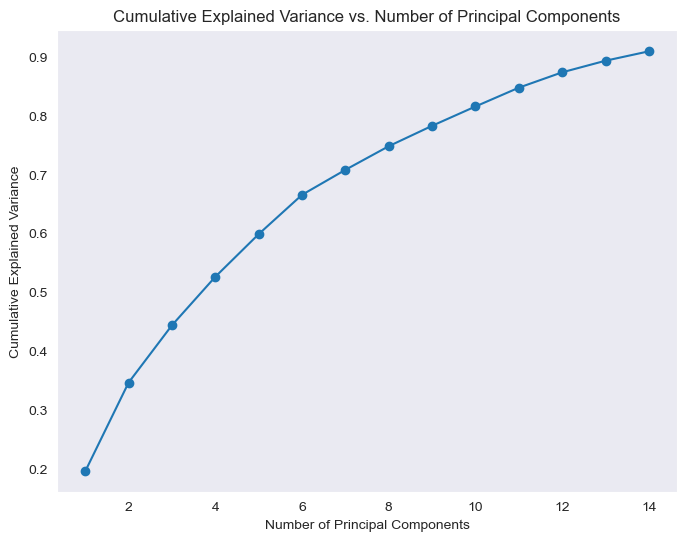

Number of PCA components selected for fasttext= 14
----------------------------------------


In [39]:
print("Dimension reduction for Fasttext")
ft_final_data = final_data(new_df3,saved_overall3, "fasttext")

In [40]:
ft_final_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Technique
2,-0.009780,0.031845,0.305013,-0.363379,0.062670,-0.279751,0.065191,0.324747,0.105763,0.317090,-0.071384,-0.027261,-0.023060,-0.071333,Doubt
3,-0.140822,-0.195694,-0.010983,0.047953,0.007903,-0.072306,0.093172,0.068713,-0.126143,0.068875,0.026450,-0.064712,0.107980,0.128339,Repetition
11,0.283391,-0.168076,0.027921,0.098274,-0.042838,-0.113860,-0.034421,-0.030105,-0.024365,-0.004306,0.023637,-0.001986,0.007958,-0.011544,Loaded_Language
12,0.025356,-0.181446,0.063626,0.034680,0.058266,-0.008029,0.052028,-0.051925,0.014329,0.032478,0.002194,0.011211,0.025550,-0.024881,Flag-Waving
13,0.008299,-0.029608,0.310951,-0.024431,0.000420,-0.187206,0.119424,0.082643,0.017241,0.030390,-0.020188,0.107987,0.015107,-0.016841,"Name_Calling,Labeling"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6123,0.034883,-0.179544,0.027116,0.098865,-0.086359,0.110064,-0.011295,-0.034730,0.062388,-0.030269,-0.081525,-0.006098,-0.016847,-0.006130,"Exaggeration,Minimisation"
6125,0.148129,-0.177525,-0.110504,0.138328,0.003688,0.055267,-0.030100,-0.047915,-0.026994,-0.016249,-0.007143,0.015520,-0.025034,-0.006968,"Exaggeration,Minimisation"
6126,-0.054903,-0.006586,0.058808,-0.205682,0.062538,0.041744,-0.021282,-0.067745,0.093811,-0.094925,0.008745,0.017923,0.003672,-0.033897,"Name_Calling,Labeling"
6127,-0.000800,-0.140748,0.040860,0.084994,0.009682,0.041865,0.002690,-0.024817,-0.032667,-0.016205,0.015184,0.026105,0.021060,0.017843,"Exaggeration,Minimisation"


In [41]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

def split_data(final_data):
    X = final_data.drop('Technique', axis=1)
    y = final_data['Technique']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test

X_train_ft, X_test_ft, y_train_ft, y_test_ft = split_data(ft_final_data)

In [48]:
# CLassification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.utils import set_random_seed
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import SimpleRNN
set_random_seed(42)
        
def random_forest(X_train, X_test, y_train, y_test, name):
        
        print(f"\t\t\tFOR {name} EMBEDDINGS")
        # Create an instance of the Random Forest classifier
        rf_classifier = RandomForestClassifier()
        # Fit the classifier to the training data
        rf_classifier.fit(X_train, y_train)
        # Predict the labels for the testing data
        y_pred = rf_classifier.predict(X_test)
        # Evaluate the performance of the classifier
        # Accuracy
        accuracy = accuracy_score(y_test, y_pred)
        #Precision, Recall, F1 Score
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        print(f'Accuracy: {accuracy:.2f}')
        print(f'Precision: {precision:.2f}')
        print(f'Recall: {recall:.2f}')
        print(f'F1 Score: {f1_score:.2f}')
        #roc_auc = roc_auc_score(y_test, y_pred)
        #print("ROC-AUC Score:", roc_auc)
        #Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        import seaborn as sns
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=propoganda_techniques_tags, yticklabels=propoganda_techniques_tags)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
        print("--------------------------------------------")                

			FOR Fasttext EMBEDDINGS
Accuracy: 0.57
Precision: 0.56
Recall: 0.57
F1 Score: 0.52


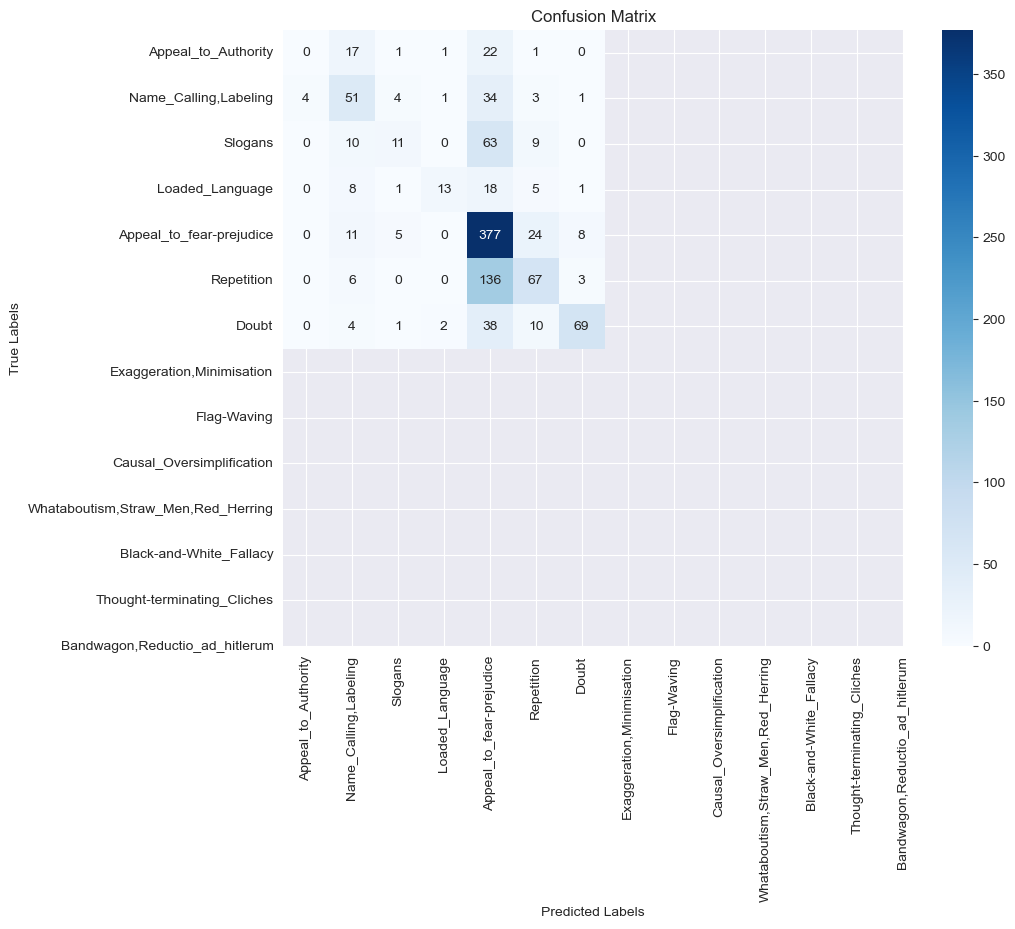

--------------------------------------------


In [47]:
random_forest(X_train_ft, X_test_ft, y_train_ft, y_test_ft,'Fasttext')

In [58]:
from keras.utils import to_categorical
def cnn(X_train, X_test, y_train, y_test, name):
    print(f"\t\t\tFOR {name} EMBEDDINGS")
    
    # Define class weights for multiclass classification
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    unique_classes = np.unique(y_train)
    class_weights_dict = {unique_classes[i]: np.mean(class_weights[y_train == unique_classes[i]]) for i in range(len(unique_classes))}
    print("Class weights: ", class_weights_dict)
    
    # Modify the model architecture for multiclass classification
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))  # Output layer with 7 units for multiclass classification
    
    # Use categorical_crossentropy as the loss function for multiclass classification
    optimizer = Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Convert to numpy and reshape if not already done
    X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='min', min_lr=0.0001)
    
    # Convert target labels to one-hot encoded vectors
    y_train_onehot = to_categorical(y_train, num_classes=7)
    y_test_onehot = to_categorical(y_test, num_classes=7)
    
    # Train the model
    model.fit(X_train, y_train_onehot, epochs=10, batch_size=128, validation_data=(X_test, y_test_onehot), class_weight=class_weights_dict, callbacks=[early_stopping, reduce_lr])
    
    # Predict probabilities and convert to predicted labels
    yhat_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(yhat_probs, axis=1)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
    # Plot confusion matrix
    cnn_conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnn_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title(f'Confusion Matrix - CNN for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
 
def cnn(X_train, X_test, y_train, y_test, name):
    print(f"\t\t\tFOR {name} EMBEDDINGS")
    # Modify the model architecture for multiclass classification
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))  # Output layer with 7 units for multiclass classification
    # Use sparse_categorical_crossentropy for integer labels
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, reduce_lr])
    # Evaluate the model
    _, accuracy = model.evaluate(X_test, y_test)
    print("Accuracy:", accuracy)
    # Plot training history (loss and accuracy)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.title(f'Model Training History - {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss/Accuracy')
    plt.show()
    # Predict probabilities and convert to predicted labels
    y_pred = np.argmax(model.predict(X_test), axis=1)
    # Evaluate additional metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    # Plot confusion matrix
    cnn_conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cnn_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title(f'Confusion Matrix - CNN for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
 
# Example usage:
# cnn(X_train, X_test, y_train, y_test, 'Word2Vec')  # Replace with your data and embeddings

In [61]:
y_test_ft

5459              Loaded_Language
1507                   Repetition
1367    Exaggeration,Minimisation
2942              Loaded_Language
4273              Loaded_Language
                  ...            
242               Loaded_Language
2243              Loaded_Language
1481        Name_Calling,Labeling
6000              Loaded_Language
3610                   Repetition
Name: Technique, Length: 1040, dtype: object

In [65]:
label_to_id = {label: i for i, label in enumerate(np.unique(y_train_ft))}
y_train = np.array([label_to_id[label] for label in y_train_ft])
y_test = np.array([label_to_id[label] for label in y_test_ft])

			FOR Fasttext EMBEDDINGS
Class weights:  {0: 3.5577416595380664, 1: 1.5041591320072332, 2: 1.592876292608196, 3: 3.2466822794691645, 4: 0.34990745414773683, 5: 0.7022965214454578, 6: 1.1954584650761715}
Epoch 1/10
33/33 [==============================] - 3s 31ms/step - loss: 1.8374 - accuracy: 0.2186 - val_loss: 1.6578 - val_accuracy: 0.2654 - lr: 0.0100
Epoch 2/10
33/33 [==============================] - 1s 20ms/step - loss: 1.6961 - accuracy: 0.2443 - val_loss: 1.6952 - val_accuracy: 0.2250 - lr: 0.0100
Epoch 3/10
33/33 [==============================] - 1s 18ms/step - loss: 1.6527 - accuracy: 0.2501 - val_loss: 1.6115 - val_accuracy: 0.1971 - lr: 0.0100
Epoch 4/10
33/33 [==============================] - 1s 18ms/step - loss: 1.6414 - accuracy: 0.2582 - val_loss: 1.6029 - val_accuracy: 0.2356 - lr: 0.0100
Epoch 5/10
33/33 [==============================] - 1s 17ms/step - loss: 1.6089 - accuracy: 0.2630 - val_loss: 1.5450 - val_accuracy: 0.3202 - lr: 0.0100
Epoch 6/10
33/33 [=======

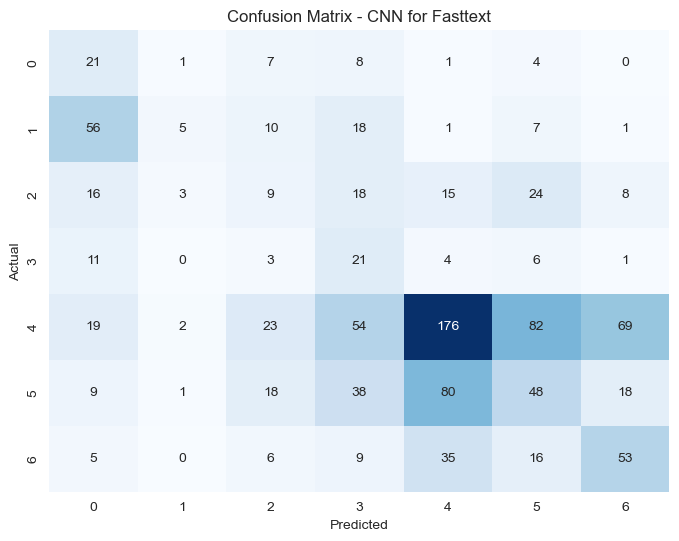

In [66]:
cnn(X_train_ft, X_test_ft, y_train, y_test, 'Fasttext')